<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Project_Generate_podcast_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Podcast Generation System using LangGraph

### Overview
This notebook demonstrates an automated podcast generation system implemented using LangGraph, Azure OpenAI, and Google's Gemini model. The system is designed to generate content for podcasts based on given topics, including keyword generation and structure planning. At the end full podcast will be generated purely based on topic given. Finally extensive (web) based function tool search is also used to augment the needed information for the topic.

### Motivation
Automated content generation systems can significantly reduce the workload for podcast creators while providing structured and relevant content. This implementation showcases how advanced AI models and graph-based workflows can be combined to create a sophisticated system that considers multiple aspects of podcast planning and content creation. Special focus is set on (web) research aspect..

### Key Components
1. State Management: Using TypedDict to define and manage the state of each customer interaction.
2. Query Categorization: Classifying customer queries into Technical, Billing, or General categories.
3. Sentiment Analysis: Determining the emotional tone of customer queries.
4. Response Generation: Creating appropriate responses based on the query category and sentiment.
5. Escalation Mechanism: Automatically escalating queries with negative sentiment to human agents.
6. Workflow Graph: Utilizing LangGraph to create a flexible and extensible workflow.

### Method
The system follows a multi-step approach to generate podcast content:

1. [Sub Graph/Agent] Planning: stage is implemented as a subgraph within the larger content generation workflow. This modular approach allows for easy extension and modification of the generation process.
2. [Sub Graph/Agent] Keyword Generation: Identifies at least 5 relevant keywords related to the podcast topic
3. [Sub Graph/Agent] Structure Generation: Creates 5 subtopics based on the podcast topic and 

4. [Main Graph/Agent] Content Generation: Likely generates detailed content for each subtopic
5. [Main Graph/Agent]
Script Formatting: Formats the content into a podcast script
6. [Main Graph/Agent]
Reconciling the individual parts: Reconciling the individual parts (intro, conclusion etc.) into coherent podcast structure.




### Implementation Details

There are two graphs. The first smaller one, is responsible for generating structure, keywords and planning all given a topic. The next main graph takes this information and implements the main logic for creating the podcast. The logic of the main graph (agent) takes these information, produces web search and generates the podcast.

The system uses LangGraph to create a structured workflow for the podcast generation process.
Custom Pydantic models (e.g., Planning, keywords, Subtopics, Structure) are used to ensure type safety and data validation throughout the process.
The notebook sets up necessary API keys and configurations for Azure OpenAI, Google Gemini, Tavily (for search), and LangSmith (for monitoring).
The planning subgraph is visualized using a Mermaid diagram, providing a clear representation of the workflow.

### Conclusion
This notebook demonstrates a sophisticated approach to automated podcast content generation by leveraging state-of-the-art AI models and graph-based workflows. The system's modular design allows for easy expansion and customization, making it adaptable to various podcast topics and formats. While the provided code focuses on the planning stage, it lays the groundwork for a comprehensive content generation system that could potentially streamline the podcast creation process.

![Podcast_Gen_LangGraph](../images/podcast_generating_system_langgraph.jpg)


### Import necessary libraries

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia google-generativeai

In [2]:
import os
import operator
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from google.colab import userdata
from IPython.display import Image, display, Markdown

In [3]:
from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, get_buffer_string

from langgraph.constants import Send
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


import google.generativeai as genai

In [4]:
from langchain_openai import AzureChatOpenAI
from langchain_community.retrievers import TavilySearchAPIRetriever

In [5]:
genai.configure(api_key=userdata.get('GEMINI_API_KEY'))
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')
os.environ["TAVILY_API_KEY"] = userdata.get('Tavily_API_key')

In [6]:
#LangSmith
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LangSmith')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "PodcastGenAI"

## Get models

In [7]:
def get_model(model:str="Agent_test", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

In [8]:
# Create the model Google Gemini
generation_config = {
  "temperature": 0.21,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 5000,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  generation_config=generation_config,
)
podcast_model = model.start_chat()

## Graphs

### Build Sub-graphs

#### Define State Structure
We define a State class to hold the topic, keywords and subtopics for each customer interaction.

In [9]:
class Planning(TypedDict):
  topic:str
  keywords: list[str]
  subtopics: list[str]

In [10]:
class keywords(BaseModel):
    """Answer with at least 5 keywords that you think are related to the topic"""
    keys: list = Field(description="list of at least 5 keywords related to the topic")

gpt_keywords = get_model("Agent_test",0.1, 50)
model_keywords = gpt_keywords.with_structured_output(keywords)

In [11]:
class Subtopics(BaseModel):
    """Answer with at least 5 subtopics related to the topic"""
    subtopics: list = Field(description="list of at least 5 subtopics related to the topic")

class Structure(BaseModel):
    """Structure of the podcast having in account the topic and the keywords"""
    subtopics: list[Subtopics] = Field(description="5 subtopics that we will review in the podcast related to the Topic and the Keywords")

gpt_structure = get_model("Agent_test",0.3, 1000)
model_structure = gpt_structure.with_structured_output(Structure)

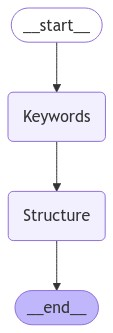

In [12]:
def get_keywords(state: Planning):
  topic = state['topic']
  messages = [SystemMessage(content="You task is to generate 5 relevant words about the following topic: " + topic)]
  message = model_keywords.invoke(messages)
  return {'keywords': message.keys}

def get_structure(state: Planning):
  topic = state['topic']
  keywords = state['keywords']
  messages = [SystemMessage(content="You task is to generate 5 subtopics to make a podcast about the following topic: " + topic +"and the following keywords:" + " ".join(keywords))]
  message = model_structure.invoke(messages)
  return { "subtopics": message.subtopics[0].subtopics}

plan_builder = StateGraph(Planning)

plan_builder.add_node("Keywords", get_keywords)
plan_builder.add_node("Structure", get_structure)
plan_builder.add_edge(START, "Keywords")
plan_builder.add_edge("Keywords", "Structure")
plan_builder.add_edge("Structure", END)

graph_plan = plan_builder.compile()

# View
display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

In [13]:
graph_plan.invoke({"topic": "What is Attention in human cognition"})

{'topic': 'What is Attention in human cognition',
 'keywords': ['focus',
  'perception',
  'cognitive load',
  'selective attention',
  'neural mechanisms'],
 'subtopics': ['Definition of Attention in Human Cognition',
  'The Role of Focus in Daily Life',
  'Understanding Cognitive Load and Its Effects on Attention',
  'Selective Attention: Mechanisms and Examples',
  'Neural Mechanisms Underlying Attention']}

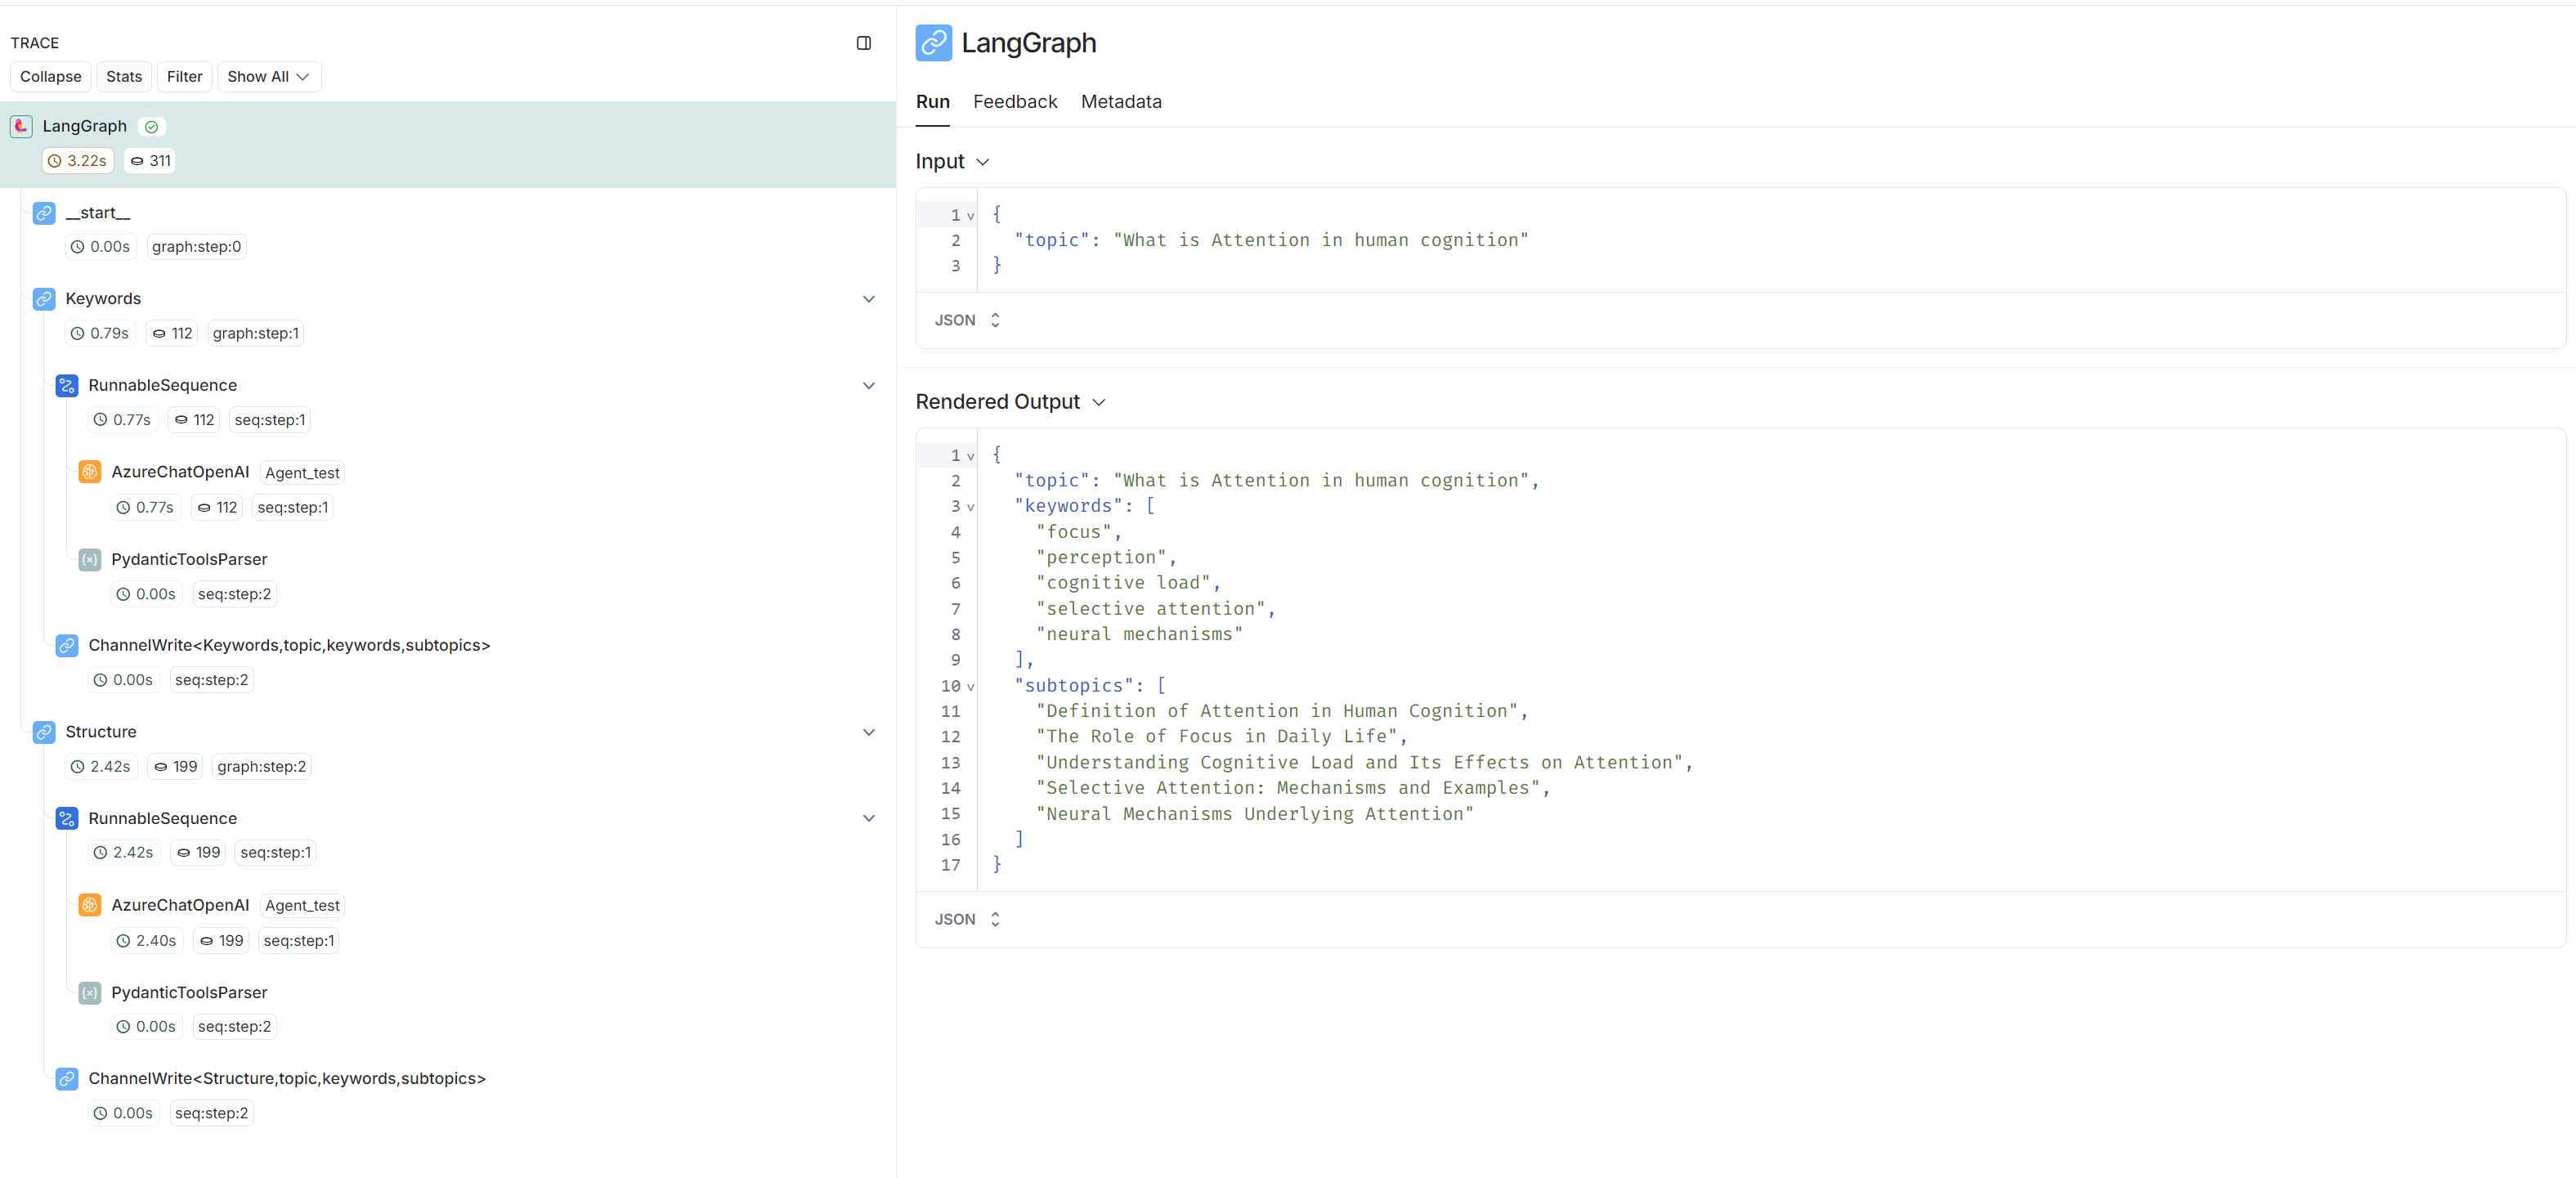

#### Conduct podcast

This is the main part, where the first subbraph is integrated into the main workflow.

In [ ]:
class InterviewState(MessagesState):
    topic: str # Topic of the podcast
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    section: str # section transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [15]:
question_instructions = """You are the host of a popular podcast and you are tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {topic}
        #
Begin by introducing the topic that fits your goals, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help"

Remember to stay in character throughout your response"""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(topic=topic)
    question = podcast_gpt.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

In [16]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

podcast_gpt = get_model(max_tokens= 1000)
structured_llm = podcast_gpt.with_structured_output(SearchQuery)

In [17]:
search_instructions = SystemMessage(content=f"""You will be given a conversation between a host of a popular podcast and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    """ Retrieve docs from web search """

    # Search query
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    tavily_search = TavilySearchResults(max_results = 3)
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    # Search query
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by a popular podcast host.
Here is the analyst's focus area: {topic}.
Your goal is to answer a question posed by the interviewer.
To answer the question, use this context:
{context}
When answering questions, follow these steps

1. Use only the information provided in the context.

2. Do not introduce outside information or make assumptions beyond what is explicitly stated in the context.

3. The context includes sources on the topic of each document.

4. Make it interesting."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    topic = state["topic"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(topic=topic, context=context)
    answer = podcast_gpt.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_podcast(state: InterviewState):

    """ save_podcast """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"section": interview}

def route_messages(state: InterviewState, name: str="expert"):
    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'Save podcast'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'Save podcast'
    return "Host question"

In [18]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create an interesting, easily digestible section of a podcast based on an interview.

1. Analyze the content of the interview

2. Create a script structure using markdown formatting

3. Make your title engaging based upon the focus area of the analyst:
{focus}

4. For the conversation:
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Mention turns of "Interviewer" and "Expert"
- Aim for approximately 1000 words maximum

5. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    section = state["section"]
    topic = state["topic"]

    system_message = section_writer_instructions.format(focus=topic)
    section_res = podcast_model.send_message(system_message + f"Use this source to write your section: {section}")

    # Append it to state
    return {"sections": [section_res.text]}

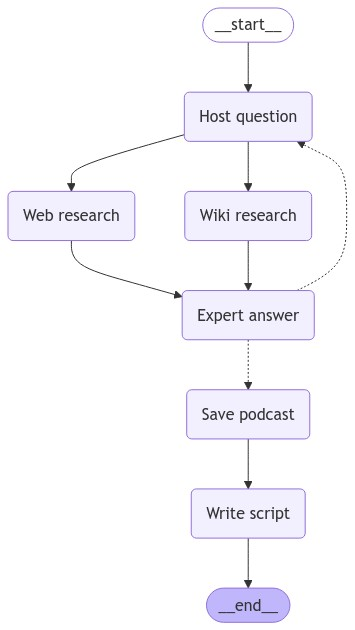

In [19]:
# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("Host question", generate_question)
interview_builder.add_node("Web research", search_web)
interview_builder.add_node("Wiki research", search_wikipedia)
interview_builder.add_node("Expert answer", generate_answer)
interview_builder.add_node("Save podcast", save_podcast)
interview_builder.add_node("Write script", write_section)

# Flow
interview_builder.add_edge(START, "Host question")
interview_builder.add_edge("Host question", "Web research")
interview_builder.add_edge("Host question", "Wiki research")
interview_builder.add_edge("Web research", "Expert answer")
interview_builder.add_edge("Wiki research", "Expert answer")
interview_builder.add_conditional_edges("Expert answer", route_messages,['Host question','Save podcast'])
interview_builder.add_edge("Save podcast", "Write script")
interview_builder.add_edge("Write script", END)

# Interview
memory = MemorySaver()
podcast_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# View
display(Image(podcast_graph.get_graph().draw_mermaid_png()))

In [20]:
messages = [HumanMessage(f"So you said you were writing an article about Attention in human cognition?")]
thread = {"configurable": {"thread_id": "1"}}
interview = podcast_graph.invoke({"topic": "The Role of Focus in Perception", "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## The Role of Focus in Perception: How Attention Shapes Our Reality

**Interviewer:** So you said you were writing an article about Attention in human cognition?

**Expert:** Absolutely! Attention plays a crucial role in how we perceive the world around us. It’s fascinating how our focus can shape our experiences and even alter our perceptions. To kick things off, could you explain how attention influences what we actually perceive? Are there any surprising examples that illustrate this?

**Expert:** Certainly! Attention significantly influences our perception by determining which stimuli we focus on while filtering out others. This selective attention is akin to a spotlight that highlights certain aspects of our environment, allowing us to process them more deeply while ignoring distractions.

A classic example is the "cocktail party effect." Imagine you're at a lively party, surrounded by chatter. Despite the noise, you can focus on a conversation with a friend. This ability to hone in on specific sounds while tuning out others showcases how our attention can shape our perception of social interactions.

**Interviewer:** That's a great example. So, it seems like our attention is constantly filtering information, but what about the "bottleneck" you mentioned?

**Expert:**  Another intriguing aspect is the concept of a "bottleneck" in attention. For instance, if you're listening to someone with a higher-pitched voice, your cognitive resources may become limited, making it harder to process other information simultaneously. This bottleneck illustrates that even when we are focused, our attention has its limits, which can lead to gaps in perception.

**Interviewer:**  That's fascinating! So, it sounds like our attention not only filters information but also shapes our experiences based on context and past experiences. Can you dive deeper into how this filtering process works? Are there specific mechanisms or theories that explain how our brains decide what to focus on?

**Expert:** Absolutely! The filtering process of attention is often explained through several key theories. One prominent model is Broadbent's Filter Theory, which suggests that our cognitive system acts as a bottleneck, allowing only certain information to pass through for further processing. This means that while we receive a vast amount of sensory input, we can only consciously attend to a limited portion at any given time.

**Interviewer:**  So, it's like a gatekeeper for our brain, only letting certain information through?

**Expert:**  Exactly! Another important concept is Treisman's Attenuation Theory, which builds on Broadbent's model. Instead of a strict filter, Treisman proposed that unattended information is not completely blocked but rather attenuated—meaning it is processed at a lower level. This allows for some relevant information, like your name in a crowded room, to break through and capture your attention.

**Interviewer:**  That makes sense. So, it's not just a complete block, but more of a dimmer switch for certain information?

**Expert:**  Precisely! Additionally, the concept of selective attention plays a crucial role. It allows us to focus on specific stimuli while ignoring others, which is essential in complex environments. For example, when you're driving, you might concentrate on the road while filtering out distractions like billboards or conversations in the car.

**Interviewer:**  So, it's like a combination of these theories that helps us navigate the world?

**Expert:**  Exactly! These mechanisms highlight how our brains prioritize information based on factors such as relevance, familiarity, and context. This prioritization is influenced by our past experiences and cultural background, which can shape what we find noteworthy or important in any given situation. Overall, attention is a dynamic process that not only filters information but also actively shapes our perception of reality. 


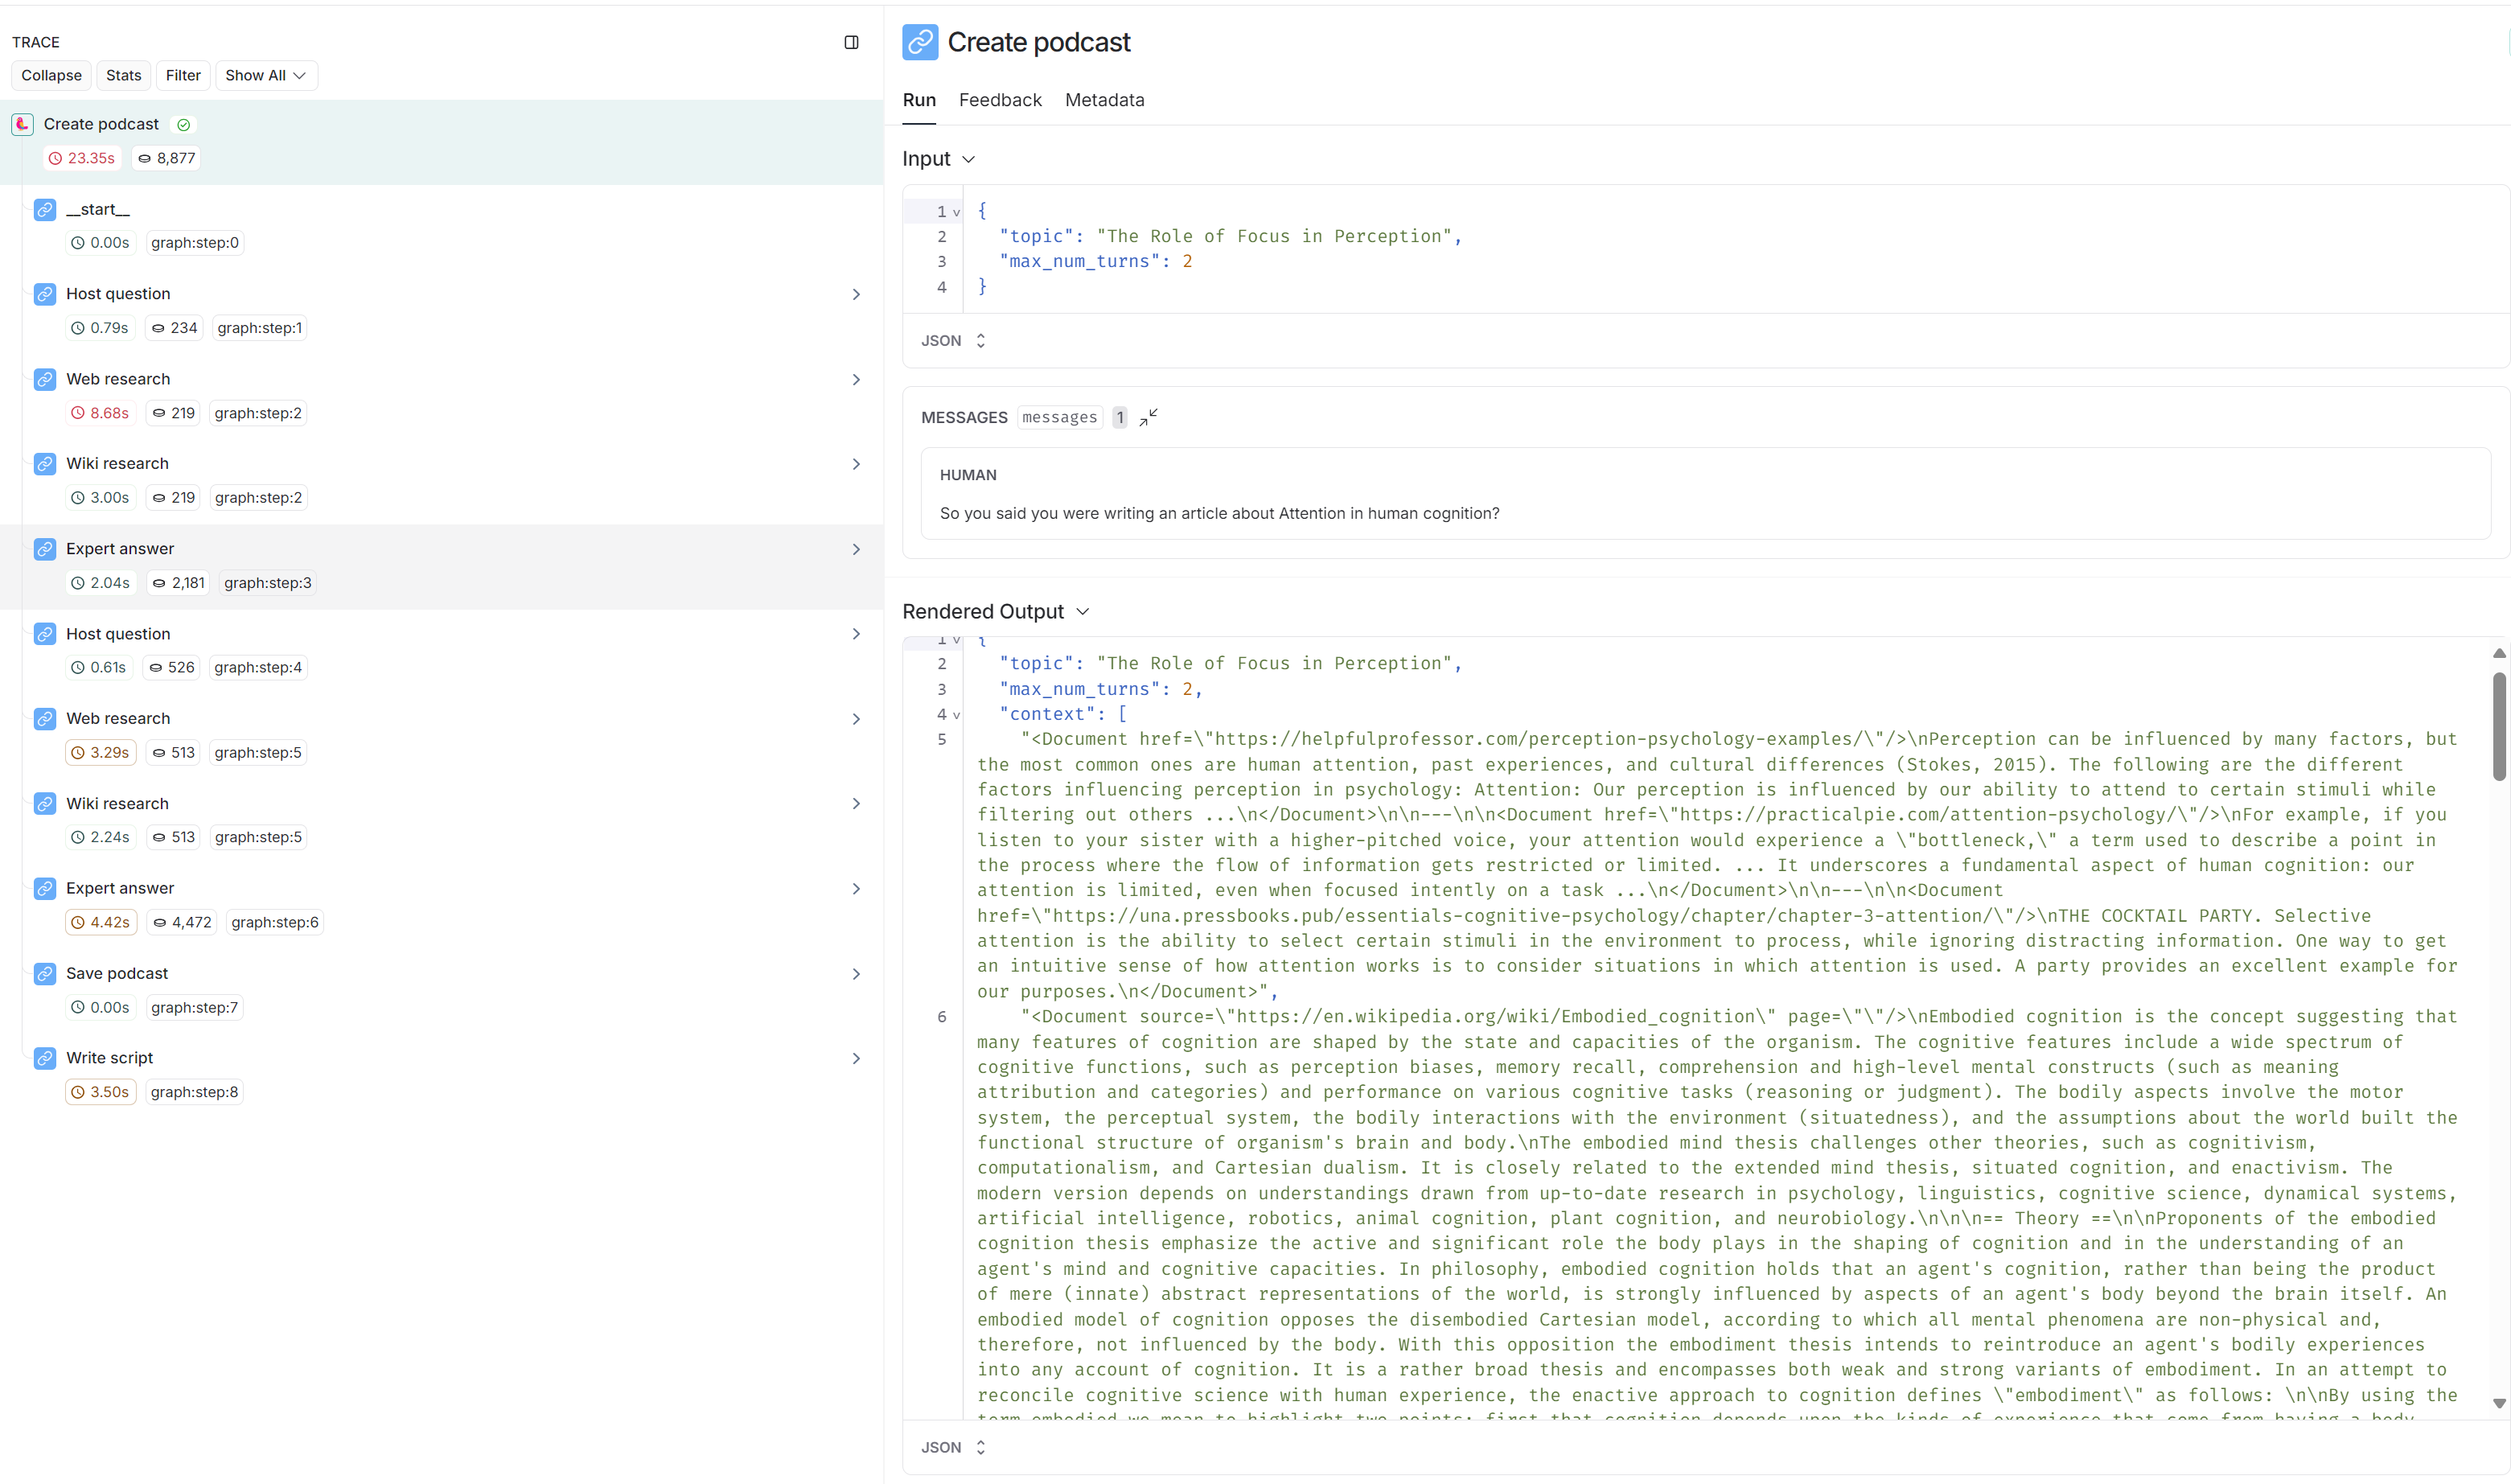

### Main graph

In [21]:
class ResearchGraphState(TypedDict):
    topic: Annotated[str, operator.add] # Research topic
    keywords: List # Keywords
    max_analysts: int # Number of analysts
    subtopics: List # Subtopics
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [22]:
report_writer_instructions = """You are a podcast script writer preparing a script for an episode on this overall topic:

{topic}

You have a dedicated researcher who has delved deep into various subtopics related to the main theme.
Your task:

1. You will be given a collection of part of script podcast from the researcher, each covering a different subtopic.
2. Carefully analyze the insights from each script.
3. Consolidate these into a crisp and engaging narrative that ties together the central ideas from all of the script, suitable for a podcast audience.
4. Weave the central points of each script into a cohesive and compelling story, ensuring a natural flow and smooth transitions between segments, creating a unified and insightful exploration of the overall topic.

To format your script:

1. Use markdown formatting.
2. Write in a conversational and engaging tone suitable for a podcast.
3. Seamlessly integrate the insights from each script into the narrative, using clear and concise language.
4. Use transitional phrases and signposting to guide the listener through the different subtopics.

Here are the scripts from the researcher to build your podcast script from:

{context}"""

In [23]:
intro_instructions = """You are a podcast producer crafting a captivating introduction for an upcoming episode on {topic}.
You will be given an outline of the episode's main segments.
Your job is to write a compelling and engaging introduction that hooks the listener and sets the stage for the discussion.
Include no unnecessary preamble or fluff.
Target around 300 words, using vivid language and intriguing questions to pique the listener's curiosity and preview the key themes and topics covered in the episode.
Use markdown formatting.
Create a catchy and relevant title for the episode and use the # header for the title.
Use ## Introduction as the section header for your introduction.
Here are the segments to draw upon for crafting your introduction: {formatted_str_sections}"""

In [24]:
conclusion_instructions = """You are a podcast producer crafting a memorable conclusion for an episode on {topic}.
You will be given an outline of the episode's main segments.
Your job is to write a concise and impactful conclusion that summarizes the key takeaways and leaves a lasting impression on the listener.
Include no unnecessary preamble or fluff.
Target around 200 words, highlighting the most important insights and offering a thought-provoking closing statement that encourages further reflection or action.
Use markdown formatting.
Use ## Conclusion as the section header for your conclusion.
Here are the segments to draw upon for crafting your conclusion: {formatted_str_sections}"""

In [25]:
# Main graph
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    topic = state["topic"]
    return [Send("Create podcast", {"topic": topic,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were researching about {subtopic}?"
                                        )
                                                    ]}) for subtopic in state["subtopics"]]

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = podcast_model.send_message(system_message)
    return {"content": report.text}

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = podcast_model.send_message(instructions)
    return {"introduction": intro.text}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = podcast_model.send_message(instructions)
    return {"conclusion": conclusion.text}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]

    return {"final_report": final_report}

def Start_parallel(state):
    """ No-op node that should be interrupted on """
    pass

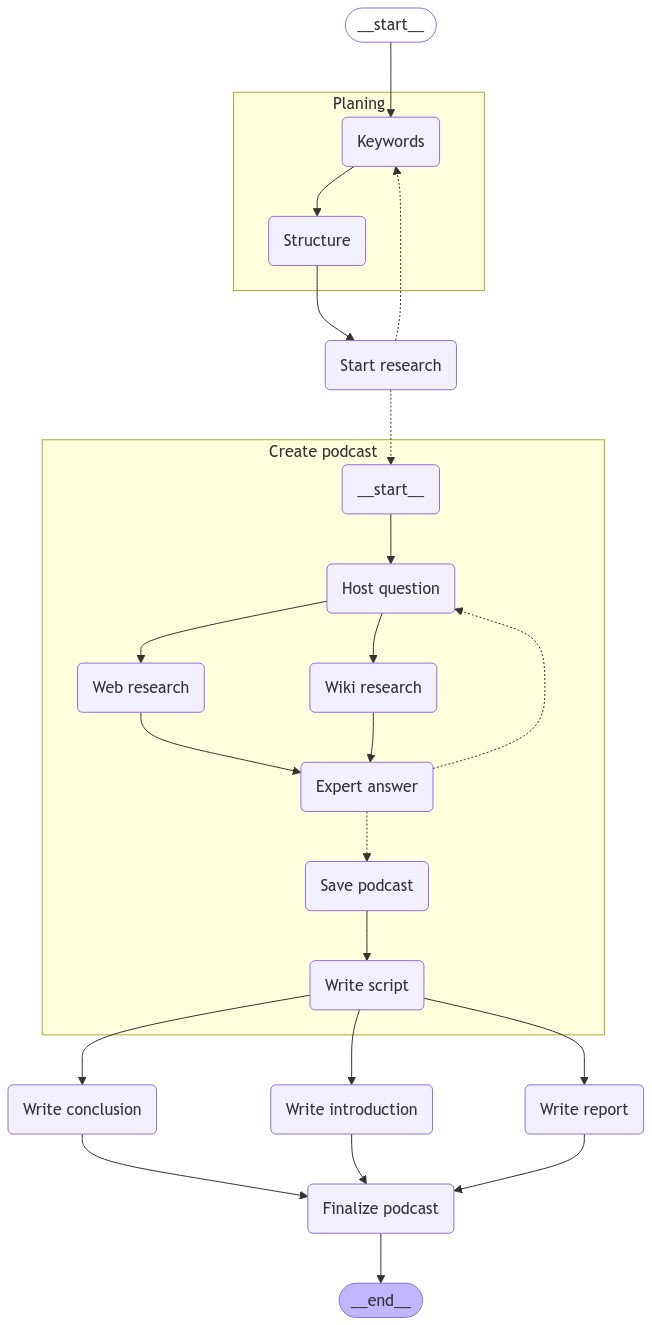

In [26]:
# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("Planing", plan_builder.compile())
builder.add_node("Start research", Start_parallel)
builder.add_node("Create podcast", interview_builder.compile())
builder.add_node("Write report",write_report)
builder.add_node("Write introduction",write_introduction)
builder.add_node("Write conclusion",write_conclusion)
builder.add_node("Finalize podcast",finalize_report)

# Logic
builder.add_edge(START, "Planing")
builder.add_edge("Planing", "Start research")
builder.add_conditional_edges("Start research", initiate_all_interviews, ["Planing", "Create podcast"])
builder.add_edge("Create podcast", "Write report")
builder.add_edge("Create podcast", "Write introduction")
builder.add_edge("Create podcast", "Write conclusion")
builder.add_edge(["Write introduction", "Write report", "Write conclusion"], "Finalize podcast")
builder.add_edge("Finalize podcast", END)

# Compile
memory = MemorySaver()
main_graph = builder.compile(checkpointer=memory)
display(Image(main_graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
# Inputs
topic = "What is Attention in human cognition"

input_g = {"topic":topic}
thread = {"configurable": {"thread_id": "1"}}

In [28]:
for event in main_graph.stream(input_g, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
Planing
--Node--
Start research
--Node--
Create podcast
--Node--
Create podcast
--Node--
Create podcast
--Node--
Create podcast
--Node--
Create podcast
--Node--
Write introduction
--Node--
Write conclusion
--Node--
Write report
--Node--
Finalize podcast


In [29]:
final_state = main_graph.get_state(thread)
report = final_state.values.get('final_report')
display(Markdown(report))

# The Spotlight in Your Mind: Unlocking the Secrets of Attention

## Introduction

Have you ever wondered why you can focus on a conversation in a crowded room, or why you can tune out distractions while working on a challenging task?  The answer lies in the fascinating world of attention, a cognitive superpower that shapes our perception, guides our decisions, and ultimately defines how we experience the world.

In this episode, we'll delve into the intricate workings of attention, exploring its surprising complexities and uncovering the secrets of how our brains manage this vital process. We'll uncover the hidden "bottleneck" that limits our ability to process information, and discover the three distinct networks in our brains that work together to control our focus. 

Join us as we unravel the mystery of attention, from the spotlight that illuminates our environment to the intricate neural mechanisms that make it possible. Get ready to learn how attention shapes our reality, and how we can harness its power to improve our focus, productivity, and overall well-being. 


---

##  The Spotlight in Your Mind: Understanding Attention

**Intro**

Hey everyone, and welcome back to the show! Today, we're diving deep into the fascinating world of attention. It's something we do all the time, but how much do we really understand about this crucial cognitive process? 

**What is Attention?**

Our expert guest today, Dr. Emily Carter, a cognitive psychologist specializing in attention and perception, is here to help us unravel the mysteries of attention. 

**Dr. Carter:** Attention is essentially the concentration of awareness on specific stimuli while filtering out irrelevant information. It's about "taking possession by the mind" of one out of several possible objects or thoughts. This selective focus allows us to engage effectively with our environment.

**Interviewer:** So, it's like a spotlight that we can shine on different things in our environment?

**Dr. Carter:** Exactly! But here's the surprising part: our attention has a limited capacity. We can only process a small fraction of the information available to us at any given moment. This means that our attentional resources are precious and must be managed wisely. 

**The Brain's Attention Network**

**Interviewer:**  That's fascinating! So, it's not just about choosing what to focus on, but also about recognizing that we can't focus on everything at once?

**Dr. Carter:**  Precisely! And to manage this, our brains have a dedicated network for attention. It's called the frontoparietal attention network, and it's made up of regions in the frontal and parietal lobes. These areas work together to prioritize and select relevant environmental information.

**Interviewer:**  So, it's like a map that helps our brain prioritize what to pay attention to?

**Dr. Carter:**  Exactly! And this network can be affected by neuropsychological disorders. Conditions like Bálint syndrome and spatial neglect provide insights into how damage to specific areas within this network can lead to significant deficits in attention and perception.

**Cognitive Load and Attention**

**Interviewer:**  That's really intriguing! So, if I understand correctly, cognitive load can either help us focus or distract us, depending on how well the information we’re processing aligns with our tasks. Can you provide a specific example from your research or experience where cognitive load significantly impacted attention in a real-world scenario? 

**Dr. Carter:** Certainly! A great example can be found in classroom settings. If the cognitive load is too high—perhaps due to the introduction of too many new variables or concepts at once—students may struggle to focus on the key principles being taught. This overload can lead to distractions, as their working memory becomes overwhelmed, making it difficult to retain any information.

**Interviewer:**  So, it's like trying to juggle too many balls at once?

**Dr. Carter:**  Exactly! On the other hand, if the teacher gradually introduces concepts, allowing students to build on their existing knowledge, the cognitive load remains manageable. This approach enhances attention because students can connect new information with what they already know, reducing distractions and improving comprehension.

**Selective Attention: Filtering the Noise**

**Interviewer:**  That's really interesting! So, it seems like cognitive load can actually make us more focused on the task at hand, but only if the information in our working memory is relevant.

**Dr. Carter:**  Exactly! And that brings us to selective attention, which is the cognitive process that enables us to focus on specific stimuli in our environment while filtering out distractions. It's like having a spotlight in our minds that highlights what’s important at any given moment.

**Interviewer:**  That's a great example! It really highlights how selective attention plays a role in our daily interactions. 

**Dr. Carter:**  Exactly! Think about being at a crowded café. You might be engaged in a conversation with a friend, tuning into their voice while ignoring the clatter of dishes and background chatter. This ability to hone in on one sound amidst a cacophony is a classic demonstration of selective attention. 

**Managing Attention in Daily Life**

**Interviewer:**  Those are all great tips! But what about daydreaming? Isn't that the opposite of focus?

**Dr. Carter:**  Interestingly, some research suggests that daydreaming can also play a role in enhancing creativity and problem-solving. While it might seem counterintuitive, allowing your mind to wander can sometimes lead to breakthroughs in focus when you return to the task.

**Interviewer:**  That's really interesting! So, it's not just about being constantly focused, but also about finding the right balance?

**Dr. Carter:**  Exactly! By incorporating these strategies, individuals can better manage their attentional resources and improve their overall focus in daily life. 

**Outro**

So there you have it, folks! Attention is a complex and fascinating process that plays a crucial role in our daily lives. By understanding how attention works, we can better manage our focus, enhance our productivity, and improve our overall well-being. 

Thanks for joining us today, and be sure to tune in next time for another exciting episode!


---

## Conclusion

Today, we've explored the fascinating world of attention, a cognitive process that shapes our perception of reality. We've learned that attention is not just about focusing on one thing, but a complex interplay of filtering, prioritizing, and allocating cognitive resources. 

We've discovered that our brains have dedicated networks for different types of attention, from the frontoparietal network that helps us control our focus to the salience network that alerts us to important stimuli. We've also learned about the concept of cognitive load and how it can either enhance or hinder our ability to focus, depending on the information we're processing.

Ultimately, understanding attention is crucial for navigating our complex world effectively. By learning to manage our attentional resources, we can improve our productivity, enhance our learning, and even improve our overall well-being. So, the next time you find yourself struggling to focus, remember the power of attention and the strategies you can use to manage it. 


In [30]:
final_state.values.get('subtopics')

['Definition of Attention in Human Cognition',
 'The Role of Focus in Daily Life',
 'Understanding Cognitive Load and Its Impact on Attention',
 'Selective Attention: How We Filter Information',
 'Neural Mechanisms Behind Attention and Focus']

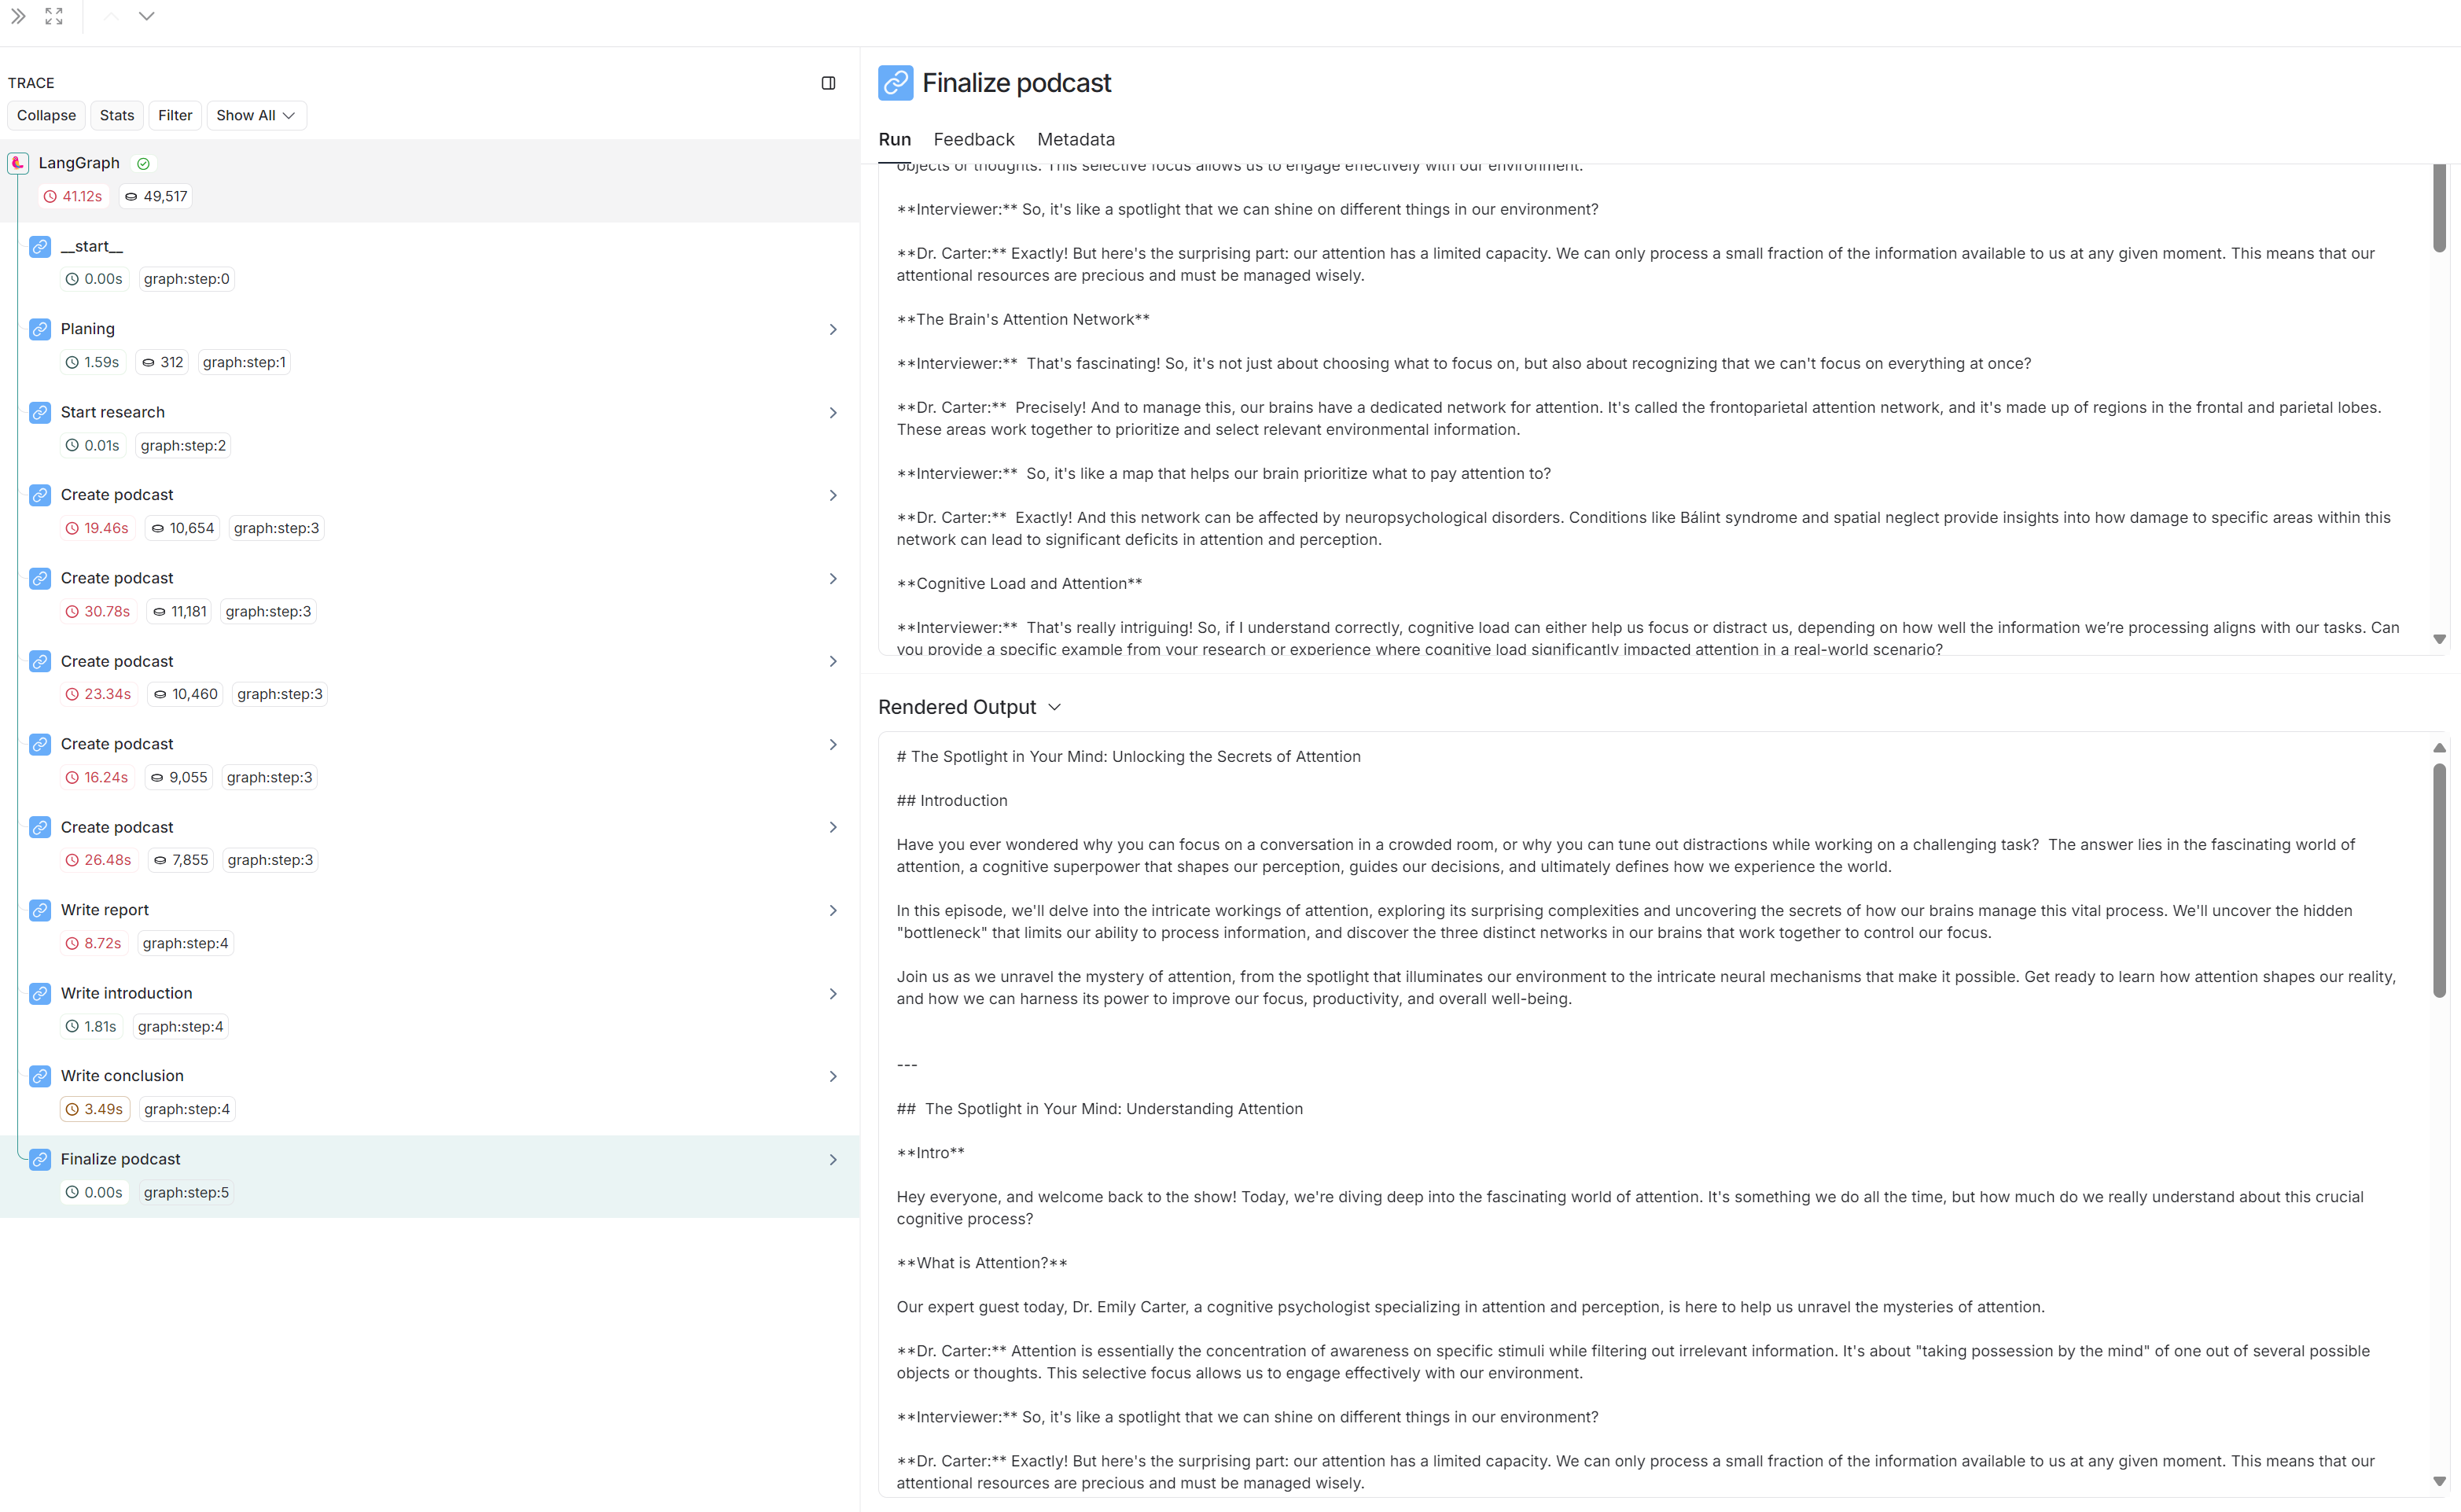